In [3]:
# Load the feed infos from 
import os
import json
from tqdm import tqdm
import pandas as pd

path = "../../Data/FeedData/full_feed_download"
files = os.listdir(path)

def get_feed_data(x):
    return {'feed_uri': x['uri'], 
    'creator_cid': x['cid'], 
    'feed_createdAt': x['value'].get('createdAt',""),
    'feed_description': x['value'].get('description',""),
    'feed_displayname': x['value'].get('displayName',"")
    }

all_feeds = []
for file in tqdm(files):
    with open(f"{path}/{file}") as f:
        data = json.load(f)
    for user in data:
        for feed in data[user]:
            feed_data = get_feed_data(feed)
            feed_data['creator_did'] = user
            all_feeds.append(feed_data)

scraped_feeds = pd.DataFrame(all_feeds)
scraped_feeds = scraped_feeds[~scraped_feeds["feed_uri"].duplicated()].reset_index(drop = True)

100%|██████████| 44/44 [00:02<00:00, 21.94it/s]


In [8]:
# Load the Feed Likers
def get_likers(liker_dict):
    results = []
    feed_uri = list(liker_dict.keys())[0]
    for liker in liker_dict[feed_uri]:
        results.append({'feed_uri': feed_uri,
                        'liker_did': liker[0],
                        'liker_dsplayname': liker[1],
                        'liker_description': liker[2],
                        'liker_createdAt': liker[3]
                         })
    return results


path = "../../Data/FeedData/feed_likes"
files = os.listdir(path)

with open(f"{path}/{files[0]}") as f:
    data = json.load(f)

scraped_likers = []

for file in tqdm(files):
    with open(f"{path}/{file}") as f:
        data = json.load(f)
    for feed in data:
        scraped_likers.extend(get_likers({feed:data[feed]}))

scraped_likers = pd.DataFrame(scraped_likers)
scraped_likers = scraped_likers.drop_duplicates(subset = ["liker_did","feed_uri"])

  0%|          | 0/18357 [00:00<?, ?it/s]

100%|██████████| 18357/18357 [00:33<00:00, 554.18it/s]


### Top Feeds - Number of Likers

In [9]:
top_feeds = pd.merge(scraped_feeds,scraped_likers.groupby("feed_uri").size().sort_values(ascending = False).head(10).reset_index(), on = "feed_uri")
top_feeds = top_feeds.loc[:,["feed_displayname","feed_description",0]]
top_feeds.columns = ["Displayname","Description","Number of Likes"]
top_feeds = top_feeds.sort_values("Number of Likes", ascending = False)
top_feeds["Description"] = top_feeds["Description"].apply(lambda x: x[0:40]+ "...")
print(top_feeds.to_latex(index_names=False))

\begin{tabular}{lllr}
\toprule
 & Displayname & Description & Number of Likes \\
\midrule
2 & For You & Learns what you like... & 16132 \\
0 & OnlyPosts & Posts from people you follow without rep... & 5137 \\
5 & Science & The Science Feed. A curated feed from Bl... & 4972 \\
3 & 🔞 Adult Content & Formerly "Suggestive". All (nonviolent) ... & 4180 \\
4 & Art & Images posted by artists on Bluesky... & 3268 \\
8 & 🐾 New & Posts by furries across Bluesky. Contain... & 3221 \\
1 & Mutuals & Posts from users who are following you b... & 3103 \\
6 & Home+ & Its the Home feed Blue Sky was missing u... & 3050 \\
9 & 🐾 Art & Posts by furries with #furryart. Contain... & 2938 \\
7 & Blacksky & Amplifying the voices of any and all Bla... & 2778 \\
\bottomrule
\end{tabular}



/home/b/dquell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Number of Likers per Feed Distribution, Number of Feeds per Person

In [5]:
num_likers_per_feed = scraped_likers.groupby("feed_uri").size().values
num_feeds_per_person = scraped_feeds.groupby('creator_did').size().values
num_likes_per_liker = scraped_likers.groupby('liker_did').size().values

In [6]:
import numpy as np
from scipy.stats import linregress

def compute_CCDF(data, normalize=True):
    x = np.sort(data)[::-1]
    counts = x.size - np.searchsorted(x[::-1],x[::-1],side='left') # we need searchsorted to take into account duplicated values

    if normalize:
        counts = np.array(counts)/ sum(counts)
    return x[::-1], counts


def find_exponent(degree_sequence, MIN):
  degree_sequence = np.array(degree_sequence)
  degree_sequence=degree_sequence[np.where(degree_sequence>=MIN)]
  return 1+len(degree_sequence)/ sum([np.log(k_i/MIN) for k_i in degree_sequence ])


def get_statistics(distribution):
    """
    Returns (dict):
        - mean μ, 
        - standard deviation σ, 
        - skewness γ, 
        - kurtosis β, 
        - minimum m, 
        - maximum M
        - mean over maximum ratio
    """
    μ = np.mean(distribution)
    σ = np.std(distribution)
    γ = np.mean((distribution - μ) ** 3) / σ ** 3
    β = np.mean((distribution - μ) ** 4) / σ ** 4
    m = np.min(distribution)
    M = np.max(distribution)
    ratio = μ/M
    #exponent, std_err = calculate_power_law_exponent(distribution)
    exponent = find_exponent(distribution, 1)
    return {
        "mean": μ,
        "std": σ,
        "skewness": γ,
        "kurtosis": β,
        "min": m,
        "max": M,
        "ratio": ratio,
        "power_law_exponent": exponent
        #"power_law_exponent_std_err": std_err
    }


results = {}
from tqdm import tqdm
import pandas as pd


for key, values in [("# Likers Per Feed", num_likers_per_feed), 
               ("# Feeds Created per Person", num_feeds_per_person), 
               ("# Number of Likes per Feed", num_likes_per_liker)]:
    results[key] = get_statistics(values)
d = pd.DataFrame(results).T
d["ratio"] = d["ratio"] * 10**3
#d.pop("power_law_exponent_std_err")
# Number of digits = 3
print(d.sort_values("mean").to_latex(float_format="%.3f").replace(".000","").replace("Number of", "\#"))

\begin{tabular}{lrrrrrrrr}
\toprule
 & mean & std & skewness & kurtosis & min & max & ratio & power_law_exponent \\
\midrule
# \# Likes per Feed & 2.128 & 5.932 & 203.296 & 60656.913 & 1 & 1799 & 1.183 & 3.413 \\
# Feeds Created per Person & 2.161 & 13.931 & 122.996 & 16082.634 & 1 & 1828 & 1.182 & 3.350 \\
# Likers Per Feed & 14.783 & 156.641 & 62.968 & 5800.619 & 1 & 16132 & 0.916 & 1.877 \\
\bottomrule
\end{tabular}



findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


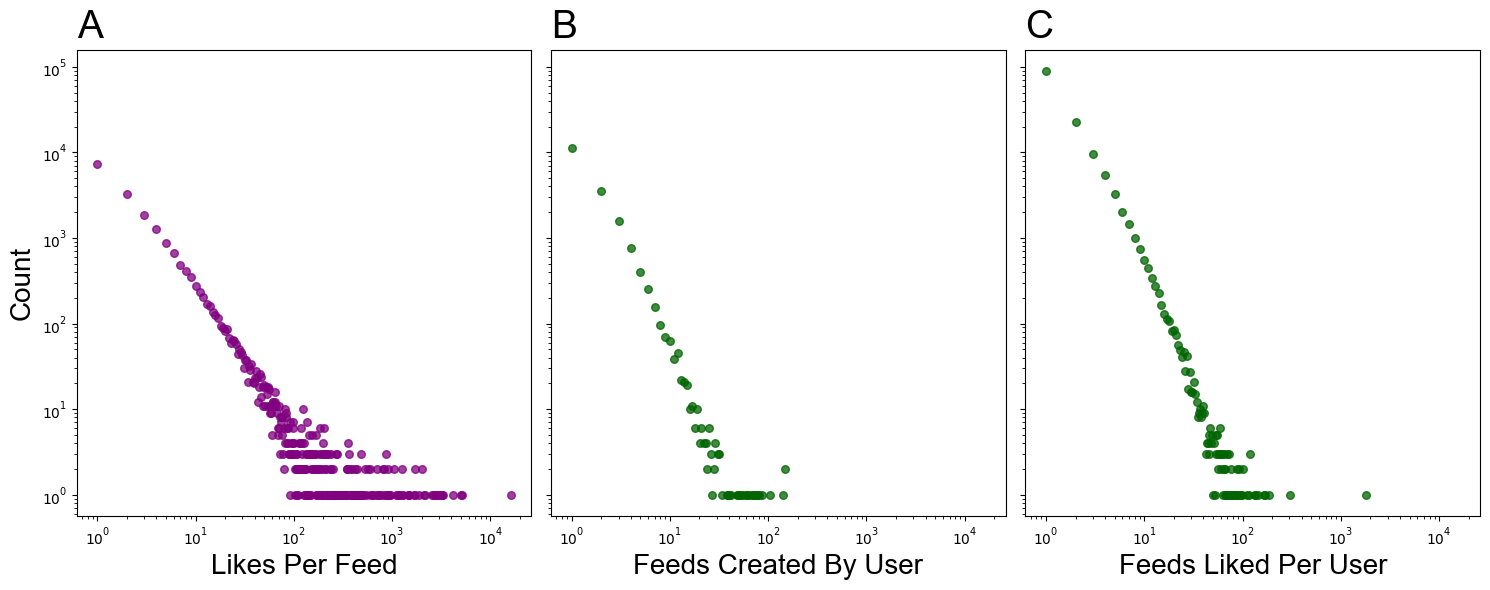

In [8]:
import matplotlib.pyplot as plt
import numpy as np 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'FreeSans']

fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True, sharex=True)
axs = axs.flatten()
fontsize = 16
titlesize = 20
markersize = 30
labsize = 18
grid_bool = False
markeralpha = 0.75
markercolor = "#0000ff"
markercolor_2 = "#800080"
markercolor_3 = "#006400"


counts = num_likers_per_feed
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=10**3)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints =  (bin_edges[:-1] * bin_edges[1:]) ** 0.5
axs[0].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#800080"
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Likes Per Feed", fontsize=titlesize)
axs[0].set_ylabel("Count", fontsize=titlesize)


counts = num_feeds_per_person
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=10**3)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5
axs[1].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#006400"
)

axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Feeds Created By User", fontsize=titlesize)

counts = num_likes_per_liker
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=10**3)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1] * bin_edges[1:]) ** 0.5
axs[2].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#006400"
)

axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel("Feeds Liked Per User", fontsize=titlesize)

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X"]
for ax in axs:
    min_val = min([ax.get_ylim()[0] for ax in axs])
    max_val = max([ax.get_ylim()[1] for ax in axs]) 
    #max_val = 10**6
    ax.set_ylim(min_val, max_val)

for idx, ax in enumerate(axs.flat):
    ax.text(0.0, 1.025, labels[idx], transform=ax.transAxes, fontsize=28)

plt.tight_layout()
plt.savefig("../Plots/Feeds_dist.png", dpi=300, bbox_inches="tight")
plt.savefig("../Plots/Feeds_dist.pdf", bbox_inches="tight")